# Introduction to using ParticleSpy

This is an example notebook for performing particle analysis using ParticleSpy.

This notebook takes a HAADF image of nanoparticles, allows the user to determine the best segmentation method and then performs analysis, producing a plot of particle areas.

Below, we load an image using Hyperspy.

In [1]:
import hyperspy.api as hs
import ParticleSpy.api as ps
import trackpy as tp

filename = '/home/jovyan/data/particlespy/SiO2 HAADF Image.hspy'
haadf = hs.load(filename)

%matplotlib notebook
haadf.plot()

ParticleSpy works by defining parameters to run segmentation. This is done through the parameters object, which can be loaded with default values.

In [3]:
params = ps.parameters()
params.generate()

Let's take a look at the default segmentation parameters.

In [4]:
params.segment

{'threshold': 'otsu',
 'watershed': False,
 'watershed_size': 0,
 'watershed_erosion': 0,
 'invert': False,
 'min_size': 0,
 'rb_kernel': 0,
 'gaussian': 0,
 'local_size': 1}

The default is a simple Otsu threshold with no other options selected. We could apply these parameters to segment the particles but we don't know how well these will work on our individual images. In order to check this out, we can use ParticleSpy's segmentation GUI. Experiment with changing the threshold algorithm and the application of watershedding to obtain the optimum labels. Once happy, click "Get Params" to print the current parameters.

In [5]:
ps.SegUI(haadf)

{'threshold': 'otsu', 'watershed': False, 'watershed_size': 0, 'watershed_erosion': 0, 'invert': False, 'min_size': 0, 'rb_kernel': 0, 'gaussian': 0, 'local_size': 1}


Next, we use the parameters saved when last pressing Update in the GUI to construct a parameter dictionary and use this to perform the segmentation.

In [24]:
params.load()
params.store['store_im'] = True
particles = ps.ParticleAnalysis(haadf,params)

c:\users\thomas slater\documents\github\particlespy\ParticleSpy\ParticleAnalysis.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  circularity = 4*3.14159265*p.properties['area']['value']/(peri**2)
c:\users\thomas slater\documents\github\particlespy\ParticleSpy\ParticleAnalysis.py:121: RuntimeWarning: divide by zero encountered in float_scalars
  p.set_property("intensity_std",((image.data - p.background)*maskp).std()/p.properties['intensity_max']['value'],None)


Let's interrogate the particle data a little bit. From an initial image we get a number of particle properties calculated automatically.

In [25]:
print(particles.list[0].properties)

{'value': 0.0008777319971692392, 'units': 'µm^2'}


It is then possible to plot a histogram of particle area.

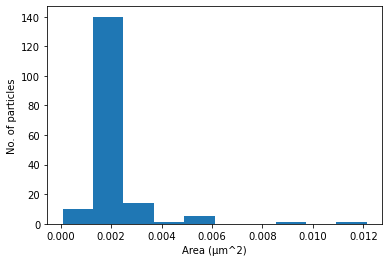

In [26]:
particles.plot()

It is also possible to plot a scatter plot of two properties. In this instance, plotting 'intensity' vs area.

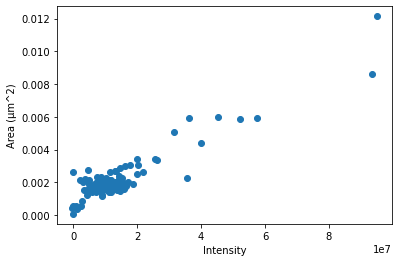

In [27]:
particles.plot(['intensity','area'])

Properties are one of the key parts of ParticleSpy. Not only can you plot them, it's possible to cluster different particles based on their properties. For example, clustering of the SiO2 particles based on both area and 'intensity':

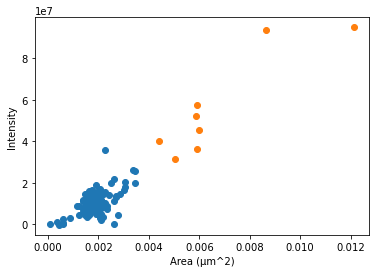

In [28]:
particles_clustered = particles.cluster_particles(properties=['area','intensity'],n_clusters=2)
ps.plot(clustered_particles,properties=['area','intensity'])

## ParticleSpy with EDS data

If you have EDS data collected simultaneously with an image, it is possible to extract maps, spectra and the composition from each segmented particle. Firstly, load the EDS spectrum image.

In [29]:
eds_filename = '/home/jovyan/data/particlespy/SiO2 EDS Spectrum Image.hspy'
eds = hs.load(eds_filename)

Next, put the HAADF image and EDS spectrum image together in a list to make one acquisition.

In [47]:
ac = [haadf.isig[0:32,0:32],eds.inav[0:32,0:32]]

At this point, we need to set the parameters for the EDS analysis. This can be done by taking our previously used parameters object adding parameters with generate_eds().

In [2]:
params.generate_eds(eds_method='CL',elements=['Si','O'], factors=[1.,1.3],store_maps=True)

Object `params.generate_eds` not found.


Now, we need to run ParticleAnalysis again in order to get the accompanying EDS data.

In [63]:
particles2 = ps.ParticleAnalysis(ac,params)

c:\users\thomas slater\documents\github\particlespy\ParticleSpy\segptcls.py:124: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  labels=thresh_image)


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


The extracted maps of each element can be accessed from the particle list from maps['element'].

C:\Users\Thomas Slater\anaconda3\envs\hyperspy_env\lib\site-packages\hyperspy\drawing\utils.py:163: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(window_title)


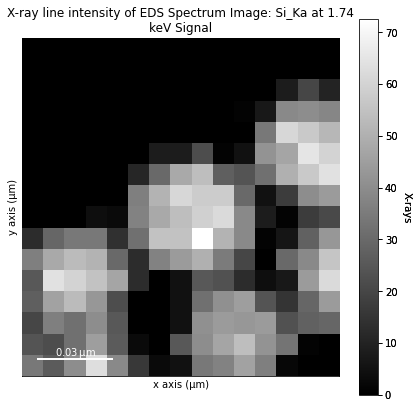

In [53]:
particles2.list[0].maps['Si']

The composition of each particle can be accessed from the particle list using list[particle].composition.

In [54]:
particles2.list[0].composition

{'O': array([46.28846993]), 'Si': array([53.71153007])}

We can plot a radial profile of the particle intensity from both the image and our elemental maps.

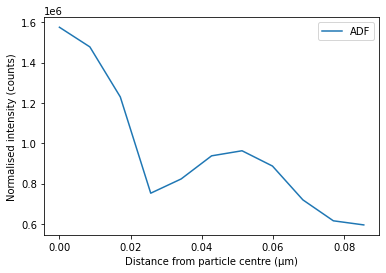

In [65]:
rp = ps.radial_profile('Image',plot=True)

In [ ]:
rp2 = ps.radial_profile(['Si','O'],plot=True)

## ParticleSpy with time-series data

ParticleSpy can also be used to track properties through a time-series of images. Let's see that in action on a short series of only 10 frames.

In [ ]:
series = hs.load('/home/jovyan/data/particlespy/particle_series.dm4')

In [ ]:
series.plot()

We'll define some new parameters that work well for this data.

In [ ]:
params_series = ps.parameters()

In [ ]:
params.generate(threshold='mean',min_size=200,gaussian=3)

For particle series, there is a modified ParticleAnalysis function called ParticleAnalysisSeries that deals with multiple frames.

In [ ]:
particles_series = ps.ParticleAnalysisSeries(series, params_series)

In [ ]:
particles_series.list[0].properties

Now we have a list of particles, with their properties attached including the frame number. We can now pass them through another function that uses the trackpy package to track the same particles through a time series.

In [ ]:
series_test = ps.timeseriesanalysis(particles_series)

The returned series_test is a pandas dataframe, which is the standard object that is used in trackpy.

We can use trackpy to do cool things like plot the trajectory of all particles in the series. Note: while the axes say they are in pixels, they are actually in nm in this case! (I have just noticed this and will fix)

In [ ]:
tp.plot_traj(series_test)

Trackpy also lets you correct for any systematic drift in the series.

In [ ]:
drift = tp.compute_drift(series_test)
d.plot()

In [ ]:
tm = tp.subtract_drift(series_test.copy(), d)
tp.plot_traj(tm)

Using the particlespy workflow for time-series data, you also have any of the properties specified in the pandas dataframe and you can plot these as a function of frame number.

In [ ]:
import matplotlib.pyplot as plt
for index, particle in tm.groupby('particle'):
    plt.plot(particle['frame'], particle['area'], label=index)